<a href="https://colab.research.google.com/github/tiasnarmi/acadamic/blob/master/Plant_Seedling_Part_1_Sharpen_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import cv2
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization


DATADIR = "/content/drive/My Drive/Plant Seedling Classification/train"
CATEGORIES = ['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']




Using TensorFlow backend.


In [0]:
# Important links for this exercise:

Converting RGB to HSV - https://www.mathworks.com/help/images/convert-from-hsv-to-rgb-color-space.html

# Pending tasks : Seeing sample image from each class



In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#!unzip "/content/drive/My Drive/Plant Seedling Classification/plant-seedlings-classification.zip" -d "/content/drive/My Drive/Plant Seedling Classification/"

In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

/content/drive/My Drive/Plant Seedling Classification/train/Black-grass


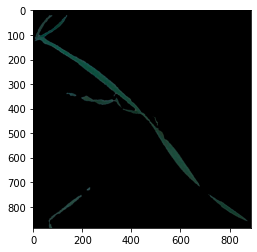

In [0]:
for category in CATEGORIES:
  path = os.path.join(DATADIR, category) # Joins actual path and the folders.
  print (path)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_COLOR) # for first read image, convert it into gray scale
    image = img_array
    image_mask = create_mask_for_plant(image)
    image_segmented = segment_plant(image)
    image_sharpen = sharpen_image(image_segmented)
    # COLOR_BGR2HSV, IMREAD_GRAYSCALE, IMREAD_COLOR
    plt.imshow(image_sharpen, cmap="gray")
    plt.show()
    break
  break
  

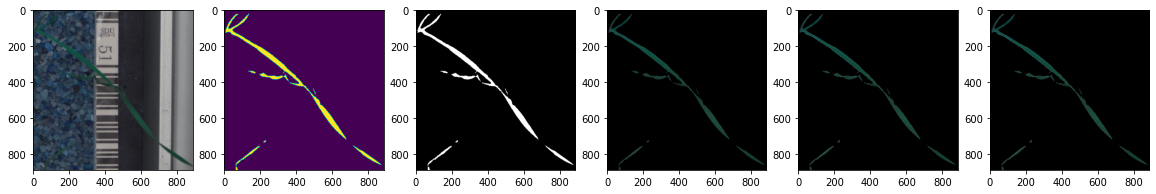

In [0]:
 #Test image to see the changes
image = img_array

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 6, figsize=(20, 20))
axs[0].imshow(image)
axs[1].imshow(image_mask)
axs[2].imshow(image_mask, cmap="gray")
axs[3].imshow(image_segmented)
axs[4].imshow(image_sharpen)
axs[5].imshow(image_sharpen, cmap="gray")
# plt.imshow(image_sharpen, cmap="gray")

(886, 886, 3)


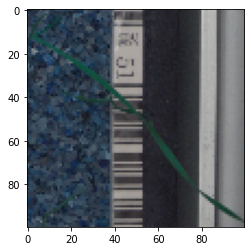

In [0]:
#   #print (img_array) # explains how the image looks in pixel intensity

# print (img_array.shape) # explains how the image shape is. each image has its own shape. 
# IMG_SIZE = 100

# new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) # explains how can we convert the image into 50x50 just to make the process easier.
# #plt.imshow(new_array, cmap = 'gray')
# plt.imshow(new_array)
# plt.show()

In [0]:
training_data = []
IMG_SIZE = 100
def create_training_data():
    for category in CATEGORIES:  # do dogs and cats

        path = os.path.join(DATADIR,category)  # create path to dogs and cats
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=dog 1=cat

        for img in tqdm(os.listdir(path)):  # iterate over each image per dogs and cats
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_COLOR)  # convert to array
                image = img_array
                image_mask = create_mask_for_plant(image)
                image_segmented = segment_plant(image)
                image_sharpen = sharpen_image(image_segmented)
                new_array = cv2.resize(image_sharpen, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
            #except OSError as e:
            #    print("OSErrroBad img most likely", e, os.path.join(path,img))
            #except Exception as e:
            #    print("general exception", e, os.path.join(path,img))
create_training_data()

import random
random.shuffle(training_data)

100%|██████████| 385/385 [06:23<00:00,  1.00it/s]


In [0]:
X = []
y = []

for features, labels in training_data: # Moving the training data to X, y format.
  X.append(features)
  y.append(labels)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3) # this resizing is just a workaround to make it numpy array. making 50x50 images. and last parm 1 represents gray scale image.

In [0]:
import pickle

pickle_out = open("/content/drive/My Drive/Plant Seedling Classification/Plant_Seedling_Image_Sharpen_image_X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Plant Seedling Classification/Plant_Seedling_Image_Sharpen_image_y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()


In [0]:
import pickle

pickle_in = open("/content/drive/My Drive/Plant Seedling Classification/Plant_Seedling_Image_Sharpen_image_X.pickle", "rb")
X = pickle.load(pickle_in)

pickle_out = open("/content/drive/My Drive/Plant Seedling Classification/Plant_Seedling_Image_Sharpen_image_y.pickle", "rb")
y = pickle.load(pickle_out)



In [0]:
num_classes = len(np.unique(y))
num_classes

12

In [0]:
print(y[10])
y = tf.keras.utils.to_categorical(y, num_classes=num_classes)
print(y[10])

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [0]:
#X = X/255

In [0]:
from sklearn.model_selection import train_test_split
RANDOM_STATE = 10
x_train, x_valid, y_train, y_valid = train_test_split(
                                                        X,
                                                        y,
                                                        shuffle=True,
                                                        test_size=0.1,
                                                        random_state=RANDOM_STATE
                                                        )

#x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=0, stratify=y)


In [0]:
x_train.shape

(4275, 100, 100, 3)

In [0]:
x_valid.shape

(475, 100, 100, 3)

In [0]:
IMG_SIZE = 100
from keras import backend as K
img_width, img_height = IMG_SIZE, IMG_SIZE

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [0]:
input_shape

(100, 100, 3)

In [0]:
# # this is the augmentation configuration we will use for training
# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     shear_range=0.2,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=True,
#     rotation_range=180,
#     width_shift_range=0.3,
#     height_shift_range=0.3)

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range = 180,
      zoom_range = 0.1,
      width_shift_range = 0.1,
      height_shift_range = 0.1,
      horizontal_flip = True,
      vertical_flip = True)

train_datagen.fit(x_train)

# this is the augmentation configuration we will use for testing:
# only rescaling
# test_datagen = ImageDataGenerator(rescale=1. / 255)


In [0]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), input_shape=input_shape, activation='relu'))   # Convolution layer
model.add(tf.keras.layers.BatchNormalization(axis=3))                                                           # Batch Normalization
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))                            # Convolution layer
model.add(tf.keras.layers.MaxPooling2D((2, 2)))                                                                 # Pooling layer
model.add(tf.keras.layers.BatchNormalization(axis=3))                                                           # Batch Normalization
model.add(tf.keras.layers.Dropout(0.1))                                                                         # Dropout layer

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=(5, 5), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.BatchNormalization(axis=3))
model.add(tf.keras.layers.Dropout(0.1))

model.add(tf.keras.layers.Flatten())                                                                            # Flatten data before giving to ANN

model.add(tf.keras.layers.Dense(256, activation='relu'))                                                        # Dense layer
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))                                             # Output layer

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 64)        4864      
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 92, 92, 64)        102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 128)       2

In [0]:
# import numpy
# numpy.random.seed(100)  # Fix seed

# model = Sequential()
# model.add(Conv2D(64,  kernel_size=(5, 5), input_shape=input_shape, activation='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(64,  kernel_size=(5, 5),  activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))


In [0]:
# model.add(Conv2D(128,  kernel_size=(5, 5),  activation='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(128,  kernel_size=(5, 5),  activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))

# model.add(Conv2D(256,  kernel_size=(5, 5), activation='relu'))
# model.add(BatchNormalization(axis=3))
# model.add(Conv2D(256,  kernel_size=(5, 5),  activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Dropout(0.1))

# model.add(Flatten())

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
# model.add(Dropout(0.5))

# model.add(Dense(12))
# model.add(Activation('softmax'))

In [0]:
# from keras.optimizers import Adam, SGD
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [0]:
# Reduce learning rate when a metric has stopped improving. Here we monitor accuracy
lrr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Save the best model after every epoch. Since accuracy is monitored, we give mode as max
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/Plant Seedling Classification/model.h5', monitor='accuracy', 
                              verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint, lrr]

# Fit the model:
model.fit_generator(train_datagen.flow(x_train, y_train, batch_size=64), 
                           epochs=40, validation_data=(x_valid, y_valid), 
                           steps_per_epoch=x_train.shape[0] // 64 , callbacks=callbacks_list)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
66/66 [==============================] - ETA: 0s - loss: 2.4242 - accuracy: 0.3011
Epoch 00001: accuracy improved from -inf to 0.30114, saving model to /content/drive/My Drive/Plant Seedling Classification/model.h5
66/66 [==============================] - 11s 170ms/step - loss: 2.4242 - accuracy: 0.3011 - val_loss: 101.1733 - val_accuracy: 0.1768 - lr: 0.0010
Epoch 2/40
66/66 [==============================] - ETA: 0s - loss: 1.5840 - accuracy: 0.4880
Epoch 00002: accuracy improved from 0.30114 to 0.48801, saving model to /content/drive/My Drive/Plant Seedling Classification/model.h5
66/66 [==============================] - 11s 162ms/step - loss: 1.5840 - accuracy: 0.4880 - val_loss: 20.4009 - val_accuracy: 0.1811 - lr: 0.0010
Epoch 3/40
66/66 [==============================] - ETA: 0s - loss: 1.3206 - accuracy: 0.5657
Epoch 00003: accuracy improved from 0.48801 to 0.56566, saving model to /content/d

In [0]:
# BATCH_SIZE = 32
# EPOCHS = 5 

# model.fit_generator(train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE),
#                   steps_per_epoch=len(x_train)/BATCH_SIZE,
#                   epochs=EPOCHS,
#                   verbose=1,
#                   shuffle=True,
#                   validation_data=(x_valid, y_valid))

# model.fit_generator(train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE),
#                   steps_per_epoch=None,
#                   epochs=EPOCHS,
#                   verbose=1,
#                   shuffle=True,
#                   validation_data=(x_valid, y_valid))

# model.fit_generator(train_generator, train_gen.n/train_gen.batch_size, 1) (new way)

# model.fit(train_datagen.flow(x_train, y_train,batch_size=BATCH_SIZE),
#                   steps_per_epoch=10*len(x_train)/BATCH_SIZE,
#                   epochs=EPOCHS,
#                   verbose=1,
#                   shuffle=True,
#                   validation_data=(x_valid, y_valid))
                  


# try:
#     model.fit_generator(gen.flow(x_train, y_train,batch_size=BATCH_SIZE),
#                   steps_per_epoch=10*len(x_train)/BATCH_SIZE,
#                   epochs=EPOCHS,
#                   verbose=1,
#                   shuffle=True,
#                   validation_dqta=(x_valid, y_valid),
#                   callbacks=callbacks)
# except:
#       print ("Something not right. check out the model") 


Epoch 1/5
  1/118 [..............................] - ETA: 0s - loss: 3.6864 - accuracy: 0.0938

KeyboardInterrupt: ignored

In [0]:
    model.save('/content/drive/My Drive/Plant Seedling Classification/plant_seedling_sharpen_image.hdf5')

In [0]:
  def test_model(img, label):
    gmodel = get_model()
    gmodel.load_weights(filepath='../input/plant-weight/model_weight_SGD.hdf5')
    prob = gmodel.predict(img, verbose=1)
    pred = prob.argmax(axis=-1)
    sub = pd.DataFrame({"file": label,
                         "species": [INV_CLASS[p] for p in pred]})
    sub.to_csv("sub.csv", index=False, header=True)